In [2]:
!pip install scanpy
import scanpy as sc
import pandas as pd
import anndata as ad
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
GSE279086_raw_adata = ad.read_h5ad("/content/03_GSE279086_seurat_pca_umap.h5ad")
GSE279086_raw_adata

AnnData object with n_obs × n_vars = 24813 × 28317
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'Sample', 'Condition', 'mahal_dist_nCount', 'pca_clusters', 'ident'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

In [4]:
GSE279086_harmony_adata = ad.read_h5ad("/content/04_GSE279086_harmony_corrected.h5ad")
GSE279086_harmony_adata

AnnData object with n_obs × n_vars = 24813 × 28317
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'Sample', 'Condition', 'mahal_dist_nCount', 'pca_clusters', 'RNA_snn_res.0.8', 'seurat_clusters', 'Harmony_clusters', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

(24813, 2)


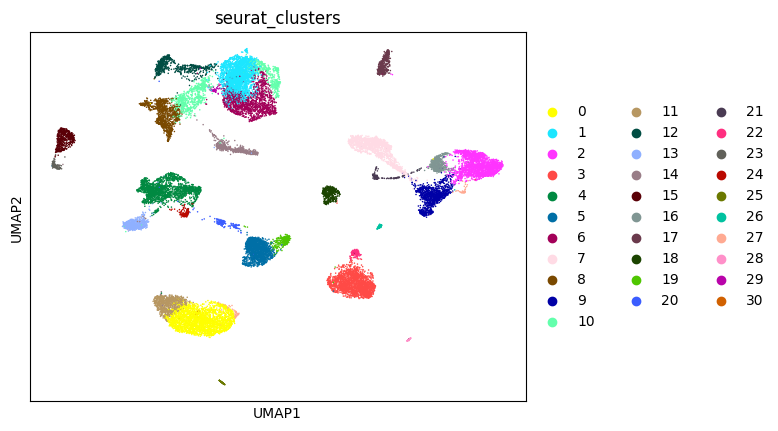

In [5]:
import pandas as pd
import numpy as np

# Load Seurat UMAP coordinates
umap_df = pd.read_csv(
    "/content/GSE279086_umap_coordinates.csv",
    index_col=0
)

# Sanity check
print(umap_df.shape)   # should be (5405, 2)

# Inject into AnnData
GSE279086_harmony_adata.obsm['X_umap'] = umap_df.loc[
    GSE279086_harmony_adata.obs_names
].values

sc.pl.umap(
    GSE279086_harmony_adata,
    color='seurat_clusters',
    show=True
)

In [6]:
# Put log-normalized counts into X (only for CellTypist)
GSE279086_harmony_adata.X = GSE279086_harmony_adata.layers['logcounts'].copy()

In [7]:
!pip install celltypist

# Import required libraries
import celltypist
from celltypist import models

/usr/local/lib/python3.12/dist-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv


In [8]:
ct_pred = celltypist.annotate(
    GSE279086_harmony_adata,
    model="/content/Adult_Human_Kidney.pkl",
    majority_voting=True
)

In [9]:
GSE279086_harmony_adata.obs['majority_voting'] = (
    ct_pred.predicted_labels['majority_voting']
    .astype(str)
)

In [10]:
print(GSE279086_harmony_adata.obs['majority_voting'].value_counts().head())

majority_voting
PC        3481
PT        3451
DTL       3270
EC-PTC    2068
VSMC/P    1317
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt

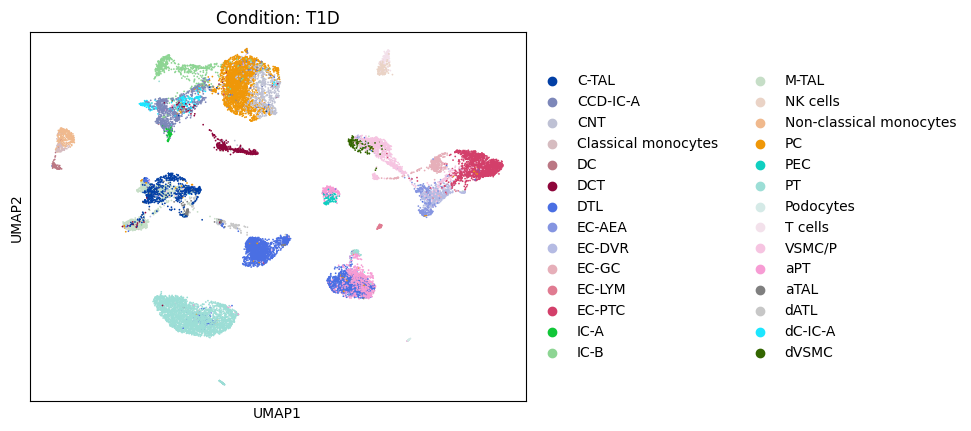

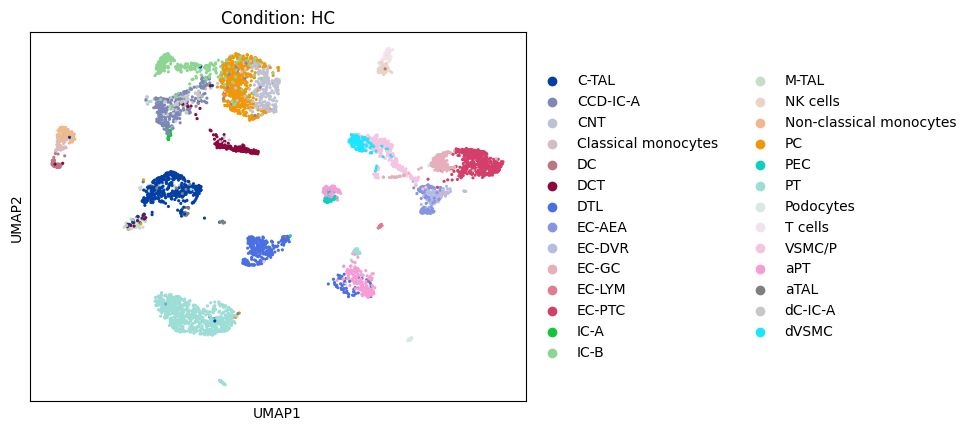

In [13]:
for cond in GSE279086_harmony_adata.obs['Condition'].unique():
    fig = sc.pl.umap(
       GSE279086_harmony_adata[
            GSE279086_harmony_adata.obs['Condition'] == cond
        ],
        color='majority_voting',
        title=f'Condition: {cond}',
        legend_loc='right margin',
        show=False,
        return_fig=True
    )
    plt.savefig(
        f"{cond}.png",
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

In [15]:
# Move log-normalized expression into X for CellTypist
GSE279086_raw_adata.X = GSE279086_raw_adata.layers['logcounts'].copy()

GSE279086_predictions3 = celltypist.annotate(
    GSE279086_raw_adata,
    model='/content/Adult_Human_Kidney.pkl',
    majority_voting=True
)

# Save majority voting to obs
GSE279086_raw_adata.obs["majority_voting"] = GSE279086_predictions3.predicted_labels["majority_voting"].astype(str)

In [17]:
import seaborn as sns

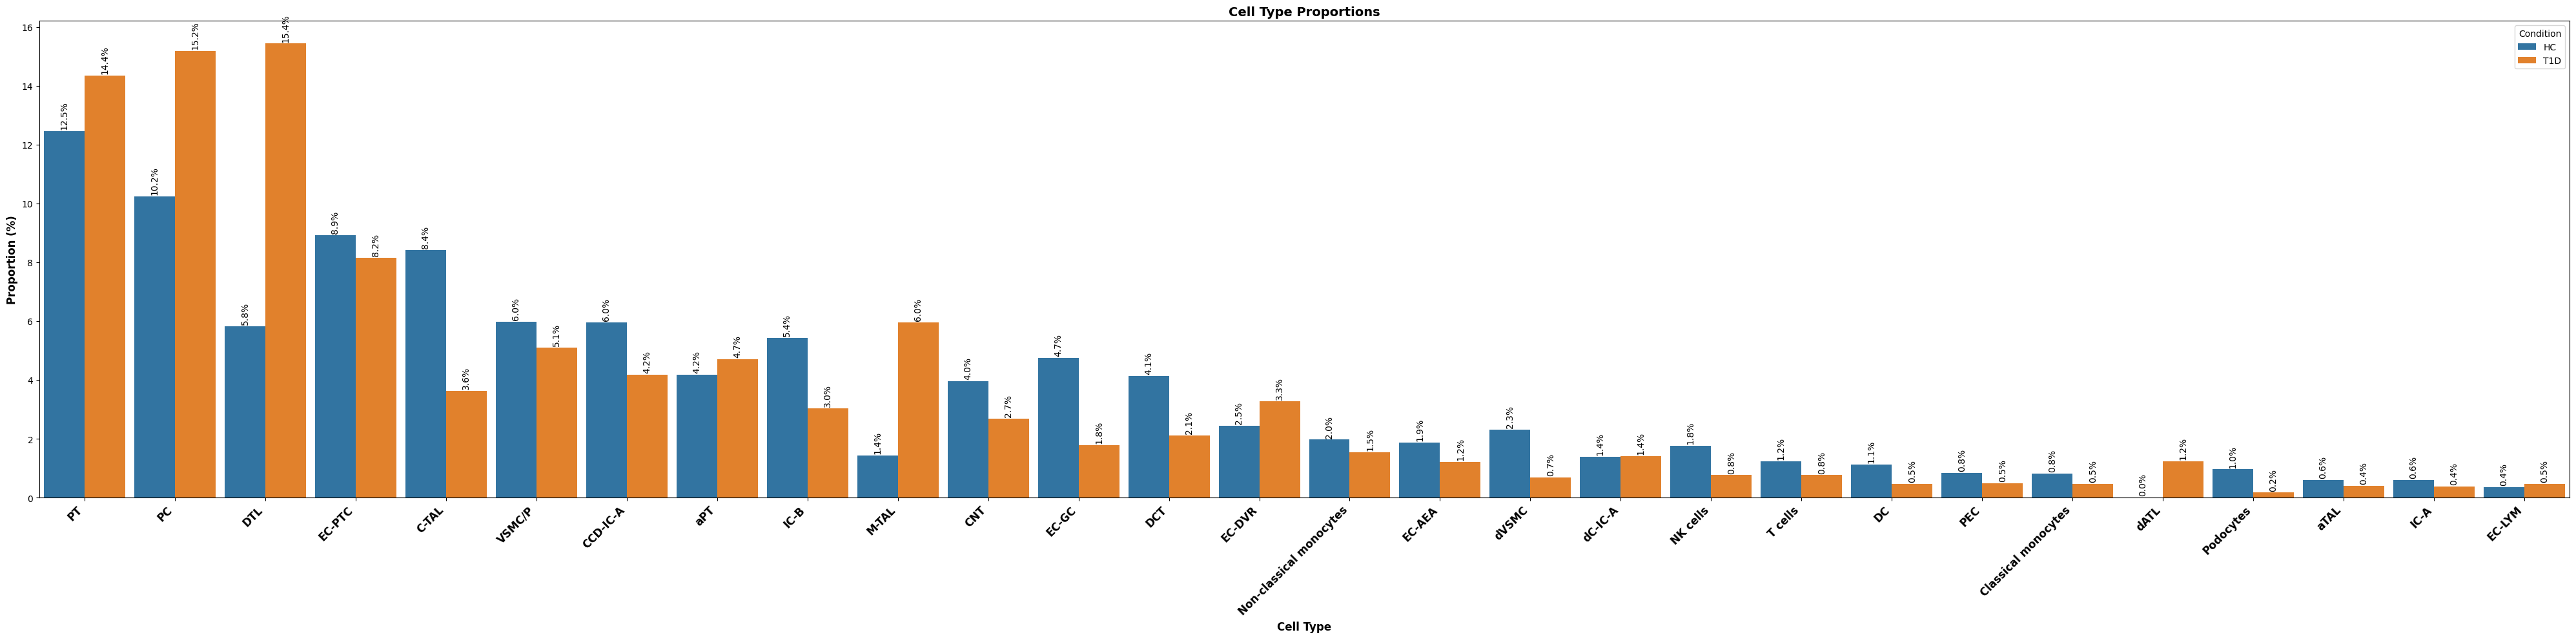

In [18]:
# Step 1: Count cells per cell type per condition
n_cells_condition = (
    GSE279086_raw_adata.obs
    .groupby(["Condition", "majority_voting"])
    .size()
    .reset_index(name="count")
)

# Step 2: Calculate proportions per condition
n_cells_condition["total"] = n_cells_condition.groupby("Condition")["count"].transform("sum")
n_cells_condition["proportion"] = (n_cells_condition["count"] / n_cells_condition["total"]) * 100

# Step 3: Compute average proportion per cell type for ordering
avg_proportions = (
    n_cells_condition
    .groupby("majority_voting")["proportion"]
    .mean()
    .sort_values(ascending=False)
)
ordered_celltypes = avg_proportions.index.tolist()

# Step 4: Plot
plt.figure(figsize=(40, 10))
ax = sns.barplot(
    data=n_cells_condition,
    x="majority_voting",
    y="proportion",
    hue="Condition",
    order=ordered_celltypes,
    dodge=True,
    width=0.9
)

# Step 5: Add proportion labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=10, rotation = 90)

# Customize axes
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.ylabel("Proportion (%)", fontsize=12, fontweight="bold")
plt.xlabel("Cell Type", fontsize=12, fontweight="bold")
plt.title("Cell Type Proportions", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("", dpi=300, bbox_inches='tight')
plt.show()

n_cells_condition.to_csv("Cellproportions.csv", index=False)

In [19]:
# Create combined group label FIRST
GSE279086_raw_adata.obs['majority_voting'] = (
    GSE279086_raw_adata.obs['majority_voting'].astype(str)
    + "_" +
   GSE279086_raw_adata.obs['Condition'].astype(str)
)

In [20]:
def find_unique_markers(
    adata,
    groupby='cell_type',
    method='wilcoxon',
    pval_threshold=0.05,
    logfc_threshold=0.25,
    top_n=3,
    min_cells_per_group=2
):
    """
    Mimics Seurat's FindAllMarkers + filters for unique DEGs per cluster.

    Parameters:
        adata : AnnData object
        groupby : column in adata.obs to group cells (e.g., clusters, cell_type)
        method : DEG test method ('wilcoxon', 't-test', 'logreg')
        pval_threshold : adjusted p-value threshold for significance
        logfc_threshold : log fold change threshold for filtering

    Returns:
        unique_degs_df : DataFrame of DEGs unique to each group
    """

    # Filter out low-cell groups
    group_counts = adata.obs[groupby].value_counts()
    valid_groups = group_counts[group_counts >= min_cells_per_group].index.tolist()

    # Subset AnnData to valid groups only
    adata_filtered = adata[adata.obs[groupby].isin(valid_groups)].copy()

    # Run DEG analysis
    sc.tl.rank_genes_groups(adata_filtered, groupby=groupby, method=method)

    # Get full results into a DataFrame
    all_degs = sc.get.rank_genes_groups_df(adata_filtered, group=None)

    # Filter by significance
    filtered_degs = all_degs[
        (all_degs['pvals_adj'] < pval_threshold) &
        (abs(all_degs['logfoldchanges']) > logfc_threshold)
    ]

    # Find genes that appear in only one group
    unique_genes = (
        filtered_degs.groupby('names')['group']
        .nunique()
        .reset_index()
        .query('group == 1')['names']
        .tolist()
    )

    # Keep only unique DEGs
    unique_degs_df = filtered_degs[filtered_degs['names'].isin(unique_genes)].copy()


    # Select top N per group by logFC
    top_unique_degs_df = (
        unique_degs_df
        .sort_values(['group', 'logfoldchanges'], ascending=[True, False])
        .groupby('group')
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_unique_degs_df

In [23]:
# Find unique markers for each cell type across conditions
# Question: "What genes define B cells vs T cells vs PT cells?"
# Compares: Cell Type A vs ALL OTHER cell types
# Purpose: Validate cell type annotations
# Output: "PT cells express SLC5A12, CUBN, LRP2"
unique_markers = sc.tl.rank_genes_groups(
    GSE279086_harmony_adata,
    groupby='majority_voting',           # Cell types from CellTypist
    reference='rest',                   # Compare each group vs all others
    method='wilcoxon',
    n_genes=50,                         # Get top 50 markers per cell type
    pval_threshold=0.05,
    logfc_threshold=0.25,
    top_n=3,
    min_cells_per_group=2,
    key_added='rank_genes_groups',      # Store results
    copy=False
)

# Extract top 3 markers per cell type
top_markers = pd.DataFrame()
for group in GSE279086_harmony_adata.obs['majority_voting'].unique():
    markers = sc.get.rank_genes_groups_df(
        GSE279086_harmony_adata,
        group=group,
        key='rank_genes_groups'
    ).head(3)
    markers['group'] = group
    top_markers = pd.concat([top_markers, markers])

# Save
top_markers.to_csv("GSE279086_celltype_markers.csv", index=False)
print(top_markers.head())

     names     scores  logfoldchanges  pvals  pvals_adj  group
0    CRYAB  65.070641        3.549713    0.0        0.0    DTL
1     TPM1  60.162655        2.894895    0.0        0.0    DTL
2    NUPR1  58.440128        3.775856    0.0        0.0    DTL
0  SLC12A1  56.123844        6.691762    0.0        0.0  C-TAL
1     UMOD  53.784077        7.111585    0.0        0.0  C-TAL


In [26]:
# ============================================
#                 OPTIONAL
# ============================================
# STEP 1: CELL TYPE ANNOTATION (DONE ✓) You have: GSE279086_harmony_adata with 'majority_voting'

# ============================================
# STEP 2: FOCUS ON PROXIMAL TUBULES (Paper Figure 3,4,5)
# ============================================
# Subset ONLY PT cells
pt_adata = GSE279086_harmony_adata[
    GSE279086_harmony_adata.obs['majority_voting'] == 'PT'
].copy()

print(f"PT cells: {pt_adata.shape[0]} cells")
print(f"T1D: {sum(pt_adata.obs['Condition'] == 'T1D')}")
print(f"HC: {sum(pt_adata.obs['Condition'] == 'HC')}")

# ============================================
# STEP 3: TCA CYCLE GENES (Paper Figure 3)
# ============================================
tca_genes = ['ACO1', 'ACO2', 'IDH1', 'IDH3A', 'OGDH', 'SDHA', 'SDHB', 'FH', 'CS']

# Run DE on PT cells only
sc.tl.rank_genes_groups(
    pt_adata,
    groupby='Condition',
    method='wilcoxon',
    key_added='PT_T1D_vs_HC'
)

# Get results
de_results = sc.get.rank_genes_groups_df(
    pt_adata,
    group='T1D',
    key='PT_T1D_vs_HC'
)

# Filter
de_results = de_results[
    (de_results['pvals_adj'] < 0.05) &
    (abs(de_results['logfoldchanges']) > 0.25)
]

# Check TCA genes
tca_results = de_results[de_results['names'].isin(tca_genes)]
print("\nTCA cycle genes in PT cells (T1D vs HC):")
print(tca_results[['names', 'logfoldchanges', 'pvals_adj']])

# Save ONE file
de_results.to_csv("GSE279086_PT_T1D_vs_HC_all_genes.csv")
tca_results.to_csv("GSE279086_PT_T1D_vs_HC_TCA_genes.csv")

PT cells: 3451 cells
T1D: 2724
HC: 727

TCA cycle genes in PT cells (T1D vs HC):
Empty DataFrame
Columns: [names, logfoldchanges, pvals_adj]
Index: []


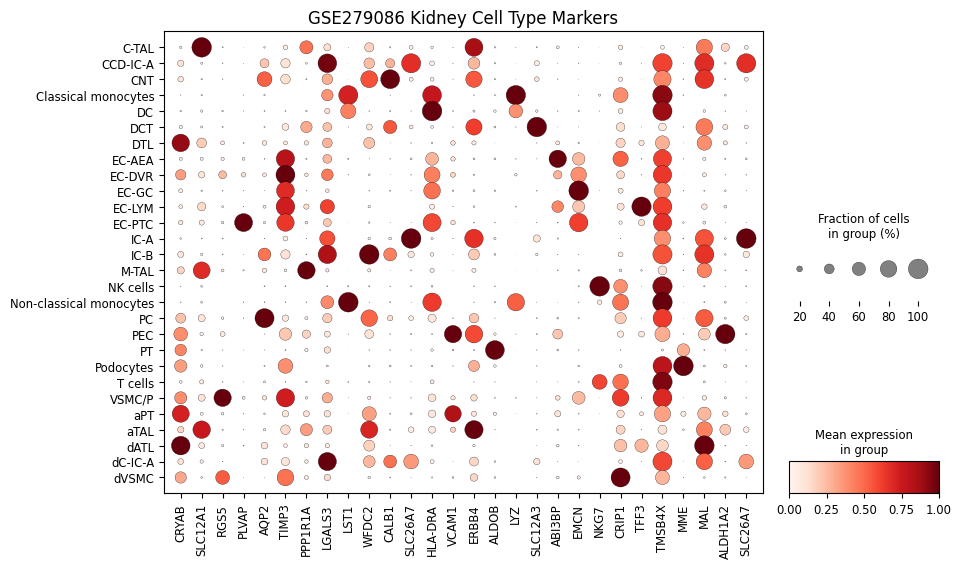

In [29]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# Load your marker genes
markers = pd.read_csv("GSE279086_celltype_markers.csv")
top_genes = markers.groupby('group').head(1)['names'].tolist()  # Top 1 per cell type

# Plot
sc.pl.dotplot(
    GSE279086_harmony_adata,
    var_names=top_genes,
    groupby='majority_voting',
    standard_scale='var',
    figsize=(10, 6),
    title='GSE279086 Kidney Cell Type Markers',
    show=False
)

plt.savefig("", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
GSE279086_raw_adata.write("GSE279086_celltypist.h5ad")